<a href="https://colab.research.google.com/github/zahra929/computer-vision/blob/master/U_NET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import os
import random
import numpy as np

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [ ]:
seed =42
np.random.seed = seed

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
TRAIN_PATH='/content/drive/My Drive/dents/train'
TEST_PATH='/content/drive/My Drive/dents/test'

train_ids= next(os.walk(TRAIN_PATH))[1]
test_ids= next(os.walk(TEST_PATH))[1]

print(train_ids)

['18', '1', '10', '16', '17', '11', '13', '12', '15', '14', '22', '24', '20', '21', '2', '25', '23', '19', '27', '26', '32', '31', '33', '36', '3', '34', '29', '28', '30', '35', '42', '44', '43', '37', '40', '38', '39', '45', '4', '41', '52', '5', '47', '50', '49', '6', '51', '7', '48', '46', '8', '9']


In [ ]:
X_train = np.zeros ((len(train_ids),IMG_HEIGHT,IMG_WIDTH , IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros(( len(train_ids),IMG_HEIGHT,IMG_WIDTH , 1 ),dtype=np.bool)

print ('resizing training images and masks')
for n, id_ in tqdm (enumerate(train_ids), total=len(train_ids)):
     path = TRAIN_PATH + '/' +id_
     img = imread(path + '/images/'+ id_ + '.jpg')[:,:,:IMG_CHANNELS]
     img= resize (img, (IMG_HEIGHT,IMG_WIDTH), mode='constant', preserve_range=True)
     X_train[n] = img
     mask = np.zeros((IMG_HEIGHT,IMG_WIDTH , 1 ),dtype=np.bool)
     for mask_file in next(os.walk(path +'/masks/'))[2]:
         mask_ = imread(path + '/masks/'+ mask_file)
         mask_ = np.expand_dims(resize (mask_, (IMG_HEIGHT,IMG_WIDTH), mode='constant', preserve_range=True),axis=-1)
         mask = np.maximum(mask, mask_)
     Y_train[n] = mask 


  0%|          | 0/52 [00:00<?, ?it/s]

resizing training images and masks


100%|██████████| 52/52 [02:16<00:00,  2.63s/it]


In [ ]:
#test images

X_test = np.zeros ((len(test_ids),IMG_HEIGHT,IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test= []

print ('resizing test images')
for n, id_ in tqdm (enumerate(test_ids), total=len(test_ids)):
     path = TEST_PATH + '/' +id_
     img = imread(path + '/images/'+ id_ + '.jpg')[:,:,:IMG_CHANNELS]
     sizes_test.append([img.shape[0], img.shape[1]])
     img= resize (img, (IMG_WIDTH, IMG_HEIGHT), mode='constant', preserve_range=True)
     X_test[n] = img

print('done')

  0%|          | 0/6 [00:00<?, ?it/s]

resizing test images


100%|██████████| 6/6 [00:22<00:00,  3.83s/it]

done


build the model

<function matplotlib.pyplot.show>

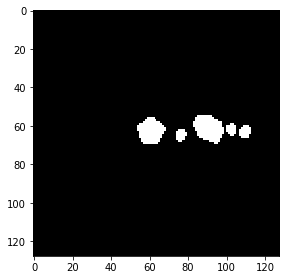

In [ ]:
image_x= random.randint(0, len(train_ids))
imshow(np.squeeze(Y_train[image_x]))
plt.show

contraction path

In [ ]:
inputs = tf.keras.layers.Input((IMG_HEIGHT,IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x /255)(inputs)

c1= tf.keras.layers.Conv2D (16 ,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1= tf.keras.layers.Conv2D (16 ,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D(2, 2)(c1)

c2= tf.keras.layers.Conv2D (32 ,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2= tf.keras.layers.Conv2D (32 ,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D(2, 2)(c2)

c3= tf.keras.layers.Conv2D (64 ,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3= tf.keras.layers.Conv2D (64 ,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D(2, 2)(c3)


c4= tf.keras.layers.Conv2D (128 ,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.1)(c4)
c4= tf.keras.layers.Conv2D (128 ,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(2, 2)(c4)

c5= tf.keras.layers.Conv2D (256 ,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.1)(c5)
c5= tf.keras.layers.Conv2D (256 ,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path

u6= tf.keras.layers.Conv2DTranspose (128, (2,2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6,c4])
c6= tf.keras.layers.Conv2D (128 ,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6= tf.keras.layers.Dropout(0.2)(c6)
c6= tf.keras.layers.Conv2D (128 ,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7= tf.keras.layers.Conv2DTranspose (64 ,(2,2), strides=(2,2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7,c3])
c7= tf.keras.layers.Conv2D (64,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7= tf.keras.layers.Dropout(0.2)(c7)
c7= tf.keras.layers.Conv2D (64 ,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8= tf.keras.layers.Conv2DTranspose (32 ,(2,2), strides=(2,2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8,c2])
c8= tf.keras.layers.Conv2D (32 ,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8= tf.keras.layers.Dropout(0.2)(c8)
c8= tf.keras.layers.Conv2D (32 ,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9= tf.keras.layers.Conv2DTranspose (16 ,(2,2), strides=(2,2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9,c1], axis=3)
c9= tf.keras.layers.Conv2D (16 ,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9= tf.keras.layers.Dropout(0.2)(c9)
c9= tf.keras.layers.Conv2D (16 ,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1,(1,1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True )

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        checkpointer]

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs= 100, callbacks=callbacks)

Epoch 1/100
3/3 [==============================] - 10s 740ms/step - loss: 0.4748 - accuracy: 0.9219 - val_loss: 0.2846 - val_accuracy: 0.9557

Epoch 00001: val_loss improved from inf to 0.28463, saving model to model_for_nuclei.h5
Epoch 2/100
3/3 [==============================] - 0s 57ms/step - loss: 0.2839 - accuracy: 0.9558 - val_loss: 0.3087 - val_accuracy: 0.9557

Epoch 00002: val_loss did not improve from 0.28463
Epoch 3/100
3/3 [==============================] - 0s 51ms/step - loss: 0.2884 - accuracy: 0.9567 - val_loss: 0.2710 - val_accuracy: 0.9557

Epoch 00003: val_loss improved from 0.28463 to 0.27101, saving model to model_for_nuclei.h5
Epoch 4/100
3/3 [==============================] - 0s 51ms/step - loss: 0.2619 - accuracy: 0.9550 - val_loss: 0.2674 - val_accuracy: 0.9557

Epoch 00004: val_loss improved from 0.27101 to 0.26738, saving model to model_for_nuclei.h5
Epoch 5/100
3/3 [==============================] - 0s 52ms/step - loss: 0.2596 - accuracy: 0.9564 - val_loss: 0

In [ ]:
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9)], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test> 0.5).astype(np.uint8)

#perform a sanity check on same random training samples

ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
ptl.show()
imshow(np.squeeze(Y_train[ix]))
ptl.show()
imshow(np.squeeze(preds_train_t[ix]))
ptl.show()

#perform a sanity check on same random validation samples

ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
ptl.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
ptl.show()
imshow(np.squeeze(preds_val_t[ix]))
ptl.show()

2/2 [==============================] - 0s 36ms/step


ValueError: ignored